# **Project name: Endoscopic Capsule**



# **Project configuration**



## Folders and files

In [103]:
## Project folder
collab_path = '/content/'
project_path = collab_path

## Imagery folders
imagery_path = ''
raw_imagery_path = '/raw/'

## Drive folder
drive_path = '/content/drive'
drive_project_path = '/MyDrive/ML_Capstone'
drive_test_path = '/test/'

## Project dataset
file_id = "1XkcoW32bK8Sq1VT_0V1Fhv0zyK-LKtjC"
file_name = "LMR_Capstone_single.zip"
classes_file = "classes_paper.csv"
#image_size = 336
image_size = 112
image_bands = 3
training_file = 'split_aa.csv'
validation_file = 'split_bb.csv'

## Training
num_epochs  = 10
retrain = False
#save_model = True
model_name = "model_cnn_lumaro"
history_name = "history"

## Environtment configuration

In [104]:
import tensorflow as tf
print(tf.version.VERSION)

2.8.0


In [105]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [106]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Setting-up the environtment (Google-Drive)

In [107]:
from google.colab import drive
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import os
if not os.path.exists(drive_path+drive_project_path):
  os.makedirs(drive_path+drive_project_path)
if not os.path.exists(drive_path+drive_project_path+drive_test_path):
  os.makedirs(drive_path+drive_project_path+drive_test_path)

## Setting-up the environtment (Collab)

In [109]:
import os
if not os.path.exists(file_name):
  !pip install gdown
  !gdown --id $file_id


In [110]:
#unzip the data
dir = project_path+imagery_path
!unzip -q -n $file_name -d $dir
dir


'/content/'

## Loading Libraries

In [111]:
import os                                               # OS module in Python provides a way of using operating system dependent functionality

import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import cv2                                              # Library for image processing

import matplotlib.pyplot as plt

import sklearn.metrics as mtc
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

# **Loading and preparing classes**


In [112]:
file = project_path+classes_file
file

'/content/classes_paper.csv'

In [113]:
classes_weights = pd.read_csv(file)   # loading the labels
classes_weights

,class,weight
0,Angiectasia,0.0285
1,Blood_fresh,1.0000
2,Erosion,0.1068
3,Erythematous,0.1667
4,Foreign_body,0.0373
5,Ileocecal_valve,0.0196
6,Lymphangiectasia,0.0982
7,Normal,0.0014
8,Pylorus,0.0235
9,Reduced_mucosal_view,0.0236


In [114]:
len(classes_weights)

11

In [115]:
dic_weights = []
vec_weights = []
for i in range(len(classes_weights)):
  vec_weights.append(classes_weights['weight'][i])
dic_weights = dict(enumerate(vec_weights))
dic_weights

{0: 0.0285,
 1: 1.0,
 2: 0.1068,
 3: 0.1667,
 4: 0.0373,
 5: 0.0196,
 6: 0.0982,
 7: 0.0014,
 8: 0.0235,
 9: 0.0236,
 10: 0.0809}

In [116]:
vec_weights

[0.0285,
 1.0,
 0.1068,
 0.1667,
 0.0373,
 0.0196,
 0.0982,
 0.0014,
 0.0235,
 0.0236,
 0.0809]

In [117]:
vec_labels = []
for i in range(len(classes_weights)):
  vec_labels.append(classes_weights['class'][i])
vec_labels

['Angiectasia',
 'Blood_fresh',
 'Erosion',
 'Erythematous',
 'Foreign_body',
 'Ileocecal_valve',
 'Lymphangiectasia',
 'Normal',
 'Pylorus',
 'Reduced_mucosal_view',
 'Ulcer']

# **Loading and preparing training data**


In [118]:
file = project_path+imagery_path+training_file
file

'/content/split_aa.csv'

In [119]:
labels = pd.read_csv(file)   # loading the labels
labels

,filename,label
0,ad91cf7ca91440aa_873.jpg,Angiectasia
1,ad91cf7ca91440aa_872.jpg,Angiectasia
2,ad91cf7ca91440aa_5961.jpg,Angiectasia
3,ad91cf7ca91440aa_5960.jpg,Angiectasia
4,ad91cf7ca91440aa_5959.jpg,Angiectasia
...,...,...
114,7a47e8eacea04e64_52388.jpg,Ulcer
115,7a47e8eacea04e64_52387.jpg,Ulcer
116,7a47e8eacea04e64_52386.jpg,Ulcer
117,7a47e8eacea04e64_52385.jpg,Ulcer


In [120]:
dir = project_path+imagery_path+'raw/'
dir

'/content/raw/'

In [121]:
file_paths = [dir + fname for fname in labels['filename']]
file_paths

['/content/raw/ad91cf7ca91440aa_873.jpg',
 '/content/raw/ad91cf7ca91440aa_872.jpg',
 '/content/raw/ad91cf7ca91440aa_5961.jpg',
 '/content/raw/ad91cf7ca91440aa_5960.jpg',
 '/content/raw/ad91cf7ca91440aa_5959.jpg',
 '/content/raw/ad91cf7ca91440aa_5958.jpg',
 '/content/raw/ad91cf7ca91440aa_5957.jpg',
 '/content/raw/ad91cf7ca91440aa_5956.jpg',
 '/content/raw/ad91cf7ca91440aa_5955.jpg',
 '/content/raw/04a78ef00c5245e0_11223.jpg',
 '/content/raw/04a78ef00c5245e0_11222.jpg',
 '/content/raw/04a78ef00c5245e0_11221.jpg',
 '/content/raw/04a78ef00c5245e0_11220.jpg',
 '/content/raw/04a78ef00c5245e0_11219.jpg',
 '/content/raw/04a78ef00c5245e0_11218.jpg',
 '/content/raw/04a78ef00c5245e0_11217.jpg',
 '/content/raw/04a78ef00c5245e0_11216.jpg',
 '/content/raw/04a78ef00c5245e0_11215.jpg',
 '/content/raw/04a78ef00c5245e0_11214.jpg',
 '/content/raw/04a78ef00c5245e0_11213.jpg',
 '/content/raw/bca26705313a4644_18164.jpg',
 '/content/raw/bca26705313a4644_18163.jpg',
 '/content/raw/bca26705313a4644_18134.jpg',

In [122]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  119 matches the number of filenames i.e.  119


#### Adding the file_paths to dataframe

In [123]:
train_data = labels
train_data['filepaths'] = file_paths
train_data      

,filename,label,filepaths
0,ad91cf7ca91440aa_873.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_873.jpg
1,ad91cf7ca91440aa_872.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_872.jpg
2,ad91cf7ca91440aa_5961.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_5961.jpg
3,ad91cf7ca91440aa_5960.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_5960.jpg
4,ad91cf7ca91440aa_5959.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_5959.jpg
...,...,...,...
114,7a47e8eacea04e64_52388.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52388.jpg
115,7a47e8eacea04e64_52387.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52387.jpg
116,7a47e8eacea04e64_52386.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52386.jpg
117,7a47e8eacea04e64_52385.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52385.jpg


In [124]:
len(train_data)

119

## Statistics of training data



In [125]:
labels = train_data['label'].unique().tolist()
labels

['Angiectasia',
 'Blood_fresh',
 'Erosion',
 'Erythematous',
 'Foreign_body',
 'Ileocecal_valve',
 'Lymphangiectasia',
 'Normal',
 'Pylorus',
 'Reduced_mucosal_view',
 'Ulcer']

In [126]:
train_data.label.value_counts()

Normal                  16
Foreign_body            14
Erosion                 13
Blood_fresh             11
Pylorus                 11
Ileocecal_valve         10
Lymphangiectasia        10
Angiectasia              9
Erythematous             9
Ulcer                    9
Reduced_mucosal_view     7
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


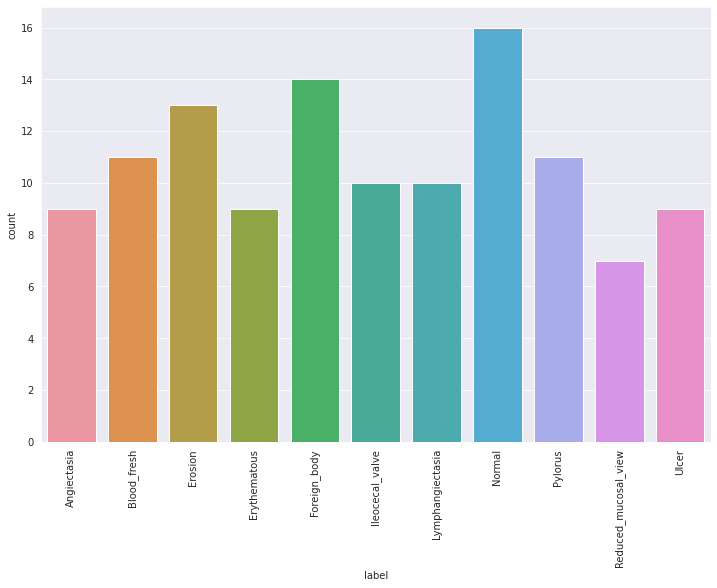

In [127]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(train_data.label)

In [128]:
def f(r):
  if r == "Angiectasia":
    return 0
  elif r == "Blood_fresh":
    return 1
  elif r == "Erosion":
    return 2
  elif r == "Erythematous":
    return 3
  elif r == "Foreign_body":
    return 4
  elif r == "Ileocecal_valve":
    return 5
  elif r == "Lymphangiectasia":
    return 6
  elif r == "Normal":
    return 7
  elif r == "Pylorus":
    return 8
  elif r == "Reduced_mucosal_view":
    return 9
  else:
    return 10

In [129]:
train_data['label'] = train_data['label'].apply(f)

In [130]:
labels = train_data['label'].unique().tolist()
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


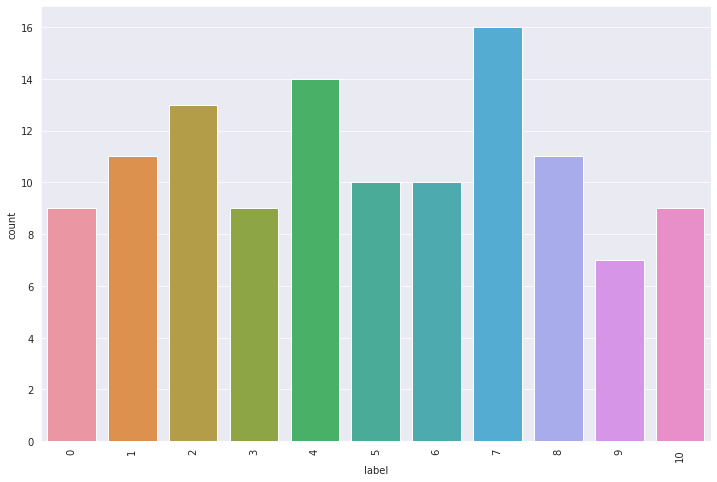

In [131]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(train_data.label)

## Training Data Pre-processing

In [132]:
from pathlib import Path
for i in tqdm(range(len(train_data))):
  if not Path(train_data['filepaths'][i]).is_file:
    print ("Error", i,train_data['filepaths'][i],train_data['label'][i])

100%|██████████| 119/119 [00:00<00:00, 31980.66it/s]


In [133]:
data = []     # initialize an empty numpy arrayis_file
for i in tqdm(range(len(train_data))):
  img_array = cv2.imread(train_data['filepaths'][i])   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  data.append([new_img_array, train_data['label'][i]])
  #data.append([img_array, train_data['label'][i]])

100%|██████████| 119/119 [00:00<00:00, 649.01it/s]


In [134]:
img_array = cv2.imread(train_data['filepaths'][0])

In [135]:
img_array.shape

(336, 336, 3)

In [136]:
img_array

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [137]:
np.random.shuffle(data)

#### Separating the images and labels


In [138]:
x_train = []
y_train = []
for image in data:
  x_train.append(image[0])
  y_train.append(image[1])

# converting x & y to numpy array as they are list
x_train = np.array(x_train)
y_train = np.array(y_train)

In [139]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 9, 11, 13,  9, 14, 10, 10, 16, 11,  7,  9]))

## Plotting some training images


In [140]:
def show_image(image,label):
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,10))
  orig_img = cv2.imread(image)
  orig_img = orig_img[..., ::-1]
  processed_img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  ax1.imshow(orig_img)
  ax2.imshow(processed_img, cmap='gray', vmin=0, vmax=255)
  ax1.set_title(f'Original Image class {label}')
  ax2.set_title(f'Processed Image class {label}')

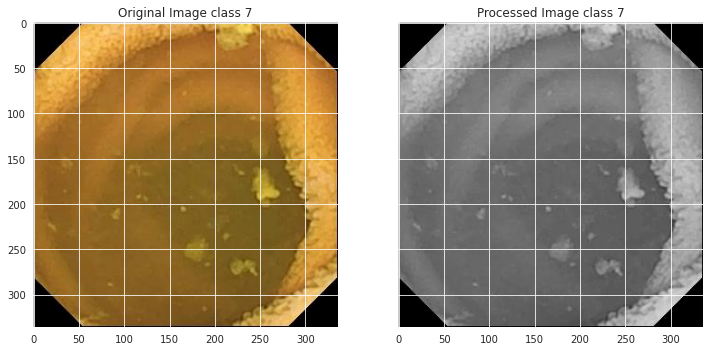

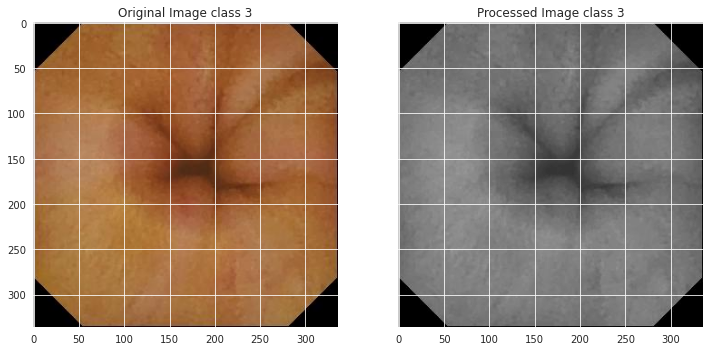

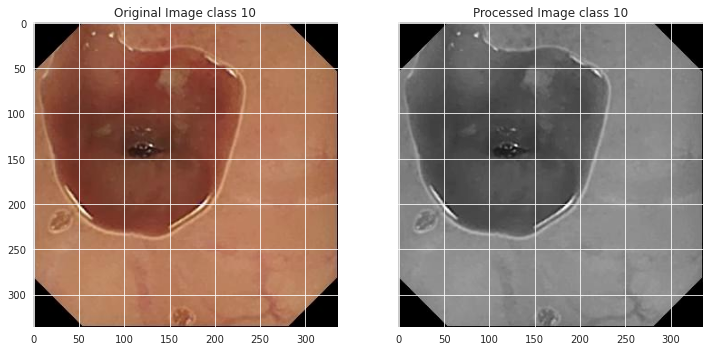

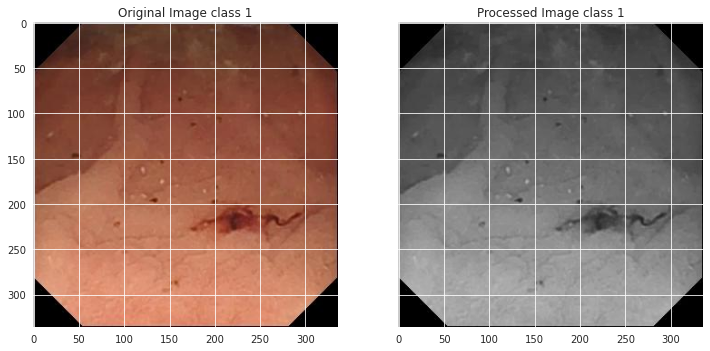

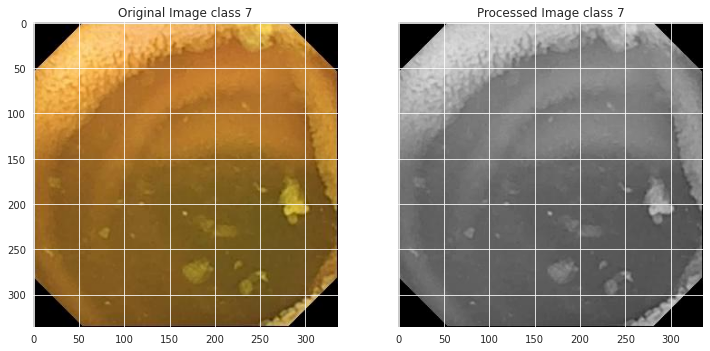

In [141]:
for i in range(5):
  i = np.random.randint(0, len(train_data) -1)
  show_image(train_data['filepaths'][i],train_data['label'][i])

# **Loading and preparing validation data**

In [142]:
file = project_path+imagery_path+validation_file
file

'/content/split_bb.csv'

In [143]:
labels = pd.read_csv(file)   # loading the labels
labels

,filename,label
0,ad91cf7ca91440aa_4754.jpg,Angiectasia
1,ad91cf7ca91440aa_4753.jpg,Angiectasia
2,64440803f87b4843_22580.jpg,Angiectasia
3,64440803f87b4843_22579.jpg,Angiectasia
4,64440803f87b4843_22578.jpg,Angiectasia
...,...,...
123,7a47e8eacea04e64_52397.jpg,Ulcer
124,7a47e8eacea04e64_52396.jpg,Ulcer
125,7a47e8eacea04e64_52395.jpg,Ulcer
126,7a47e8eacea04e64_52394.jpg,Ulcer


In [144]:
dir = project_path+imagery_path+'raw/'
dir

'/content/raw/'

In [145]:
file_paths = [dir + fname for fname in labels['filename']]
file_paths

['/content/raw/ad91cf7ca91440aa_4754.jpg',
 '/content/raw/ad91cf7ca91440aa_4753.jpg',
 '/content/raw/64440803f87b4843_22580.jpg',
 '/content/raw/64440803f87b4843_22579.jpg',
 '/content/raw/64440803f87b4843_22578.jpg',
 '/content/raw/64440803f87b4843_21417.jpg',
 '/content/raw/64440803f87b4843_21416.jpg',
 '/content/raw/64440803f87b4843_21415.jpg',
 '/content/raw/64440803f87b4843_21395.jpg',
 '/content/raw/04a78ef00c5245e0_11235.jpg',
 '/content/raw/04a78ef00c5245e0_11234.jpg',
 '/content/raw/04a78ef00c5245e0_11233.jpg',
 '/content/raw/04a78ef00c5245e0_11232.jpg',
 '/content/raw/04a78ef00c5245e0_11231.jpg',
 '/content/raw/04a78ef00c5245e0_11229.jpg',
 '/content/raw/04a78ef00c5245e0_11228.jpg',
 '/content/raw/04a78ef00c5245e0_11227.jpg',
 '/content/raw/04a78ef00c5245e0_11226.jpg',
 '/content/raw/04a78ef00c5245e0_11225.jpg',
 '/content/raw/04a78ef00c5245e0_11224.jpg',
 '/content/raw/bca26705313a4644_20404.jpg',
 '/content/raw/bca26705313a4644_20403.jpg',
 '/content/raw/bca26705313a4644_20

In [146]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  128 matches the number of filenames i.e.  128


#### Adding the file_paths to dataframe

In [147]:
val_data = labels
val_data['filepaths'] = file_paths
val_data      

,filename,label,filepaths
0,ad91cf7ca91440aa_4754.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_4754.jpg
1,ad91cf7ca91440aa_4753.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_4753.jpg
2,64440803f87b4843_22580.jpg,Angiectasia,/content/raw/64440803f87b4843_22580.jpg
3,64440803f87b4843_22579.jpg,Angiectasia,/content/raw/64440803f87b4843_22579.jpg
4,64440803f87b4843_22578.jpg,Angiectasia,/content/raw/64440803f87b4843_22578.jpg
...,...,...,...
123,7a47e8eacea04e64_52397.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52397.jpg
124,7a47e8eacea04e64_52396.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52396.jpg
125,7a47e8eacea04e64_52395.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52395.jpg
126,7a47e8eacea04e64_52394.jpg,Ulcer,/content/raw/7a47e8eacea04e64_52394.jpg


In [148]:
len(val_data)

128

## Statistics of validation data



In [149]:
labels = val_data['label'].unique().tolist()
labels

['Angiectasia',
 'Blood_fresh',
 'Erosion',
 'Erythematous',
 'Foreign_Bodies',
 'Ileocecal_valve',
 'Lymphangiectasia',
 'Normal',
 'Pylorus',
 'Reduced_mucosal_view',
 'Ulcer']

In [150]:
val_data.label.value_counts()

Reduced_mucosal_view    21
Normal                  18
Blood_fresh             11
Erosion                 11
Pylorus                 11
Ulcer                   11
Ileocecal_valve         10
Angiectasia              9
Erythematous             9
Lymphangiectasia         9
Foreign_Bodies           8
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


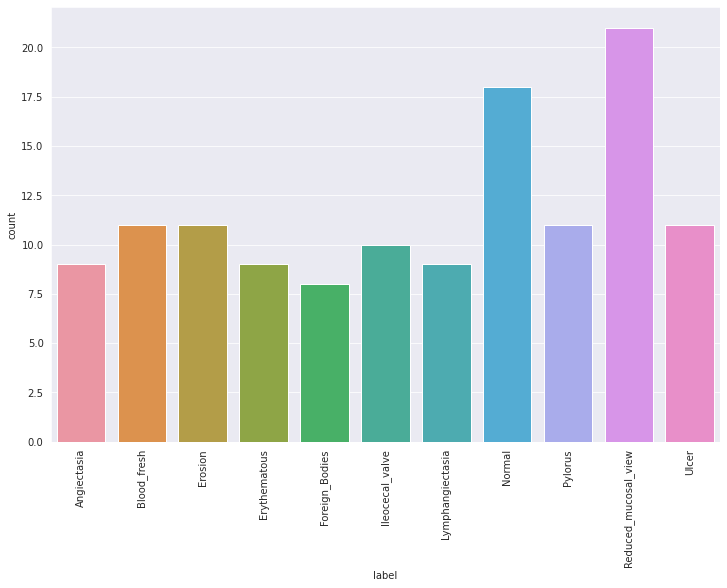

In [151]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(val_data.label)

In [152]:
def f(r):
  if r == "Angiectasia":
    return 0
  elif r == "Blood_fresh":
    return 1
  elif r == "Erosion":
    return 2
  elif r == "Erythematous":
    return 3
  elif r == "Foreign_body":
    return 4
  elif r == "Ileocecal_valve":
    return 5
  elif r == "Lymphangiectasia":
    return 6
  elif r == "Normal":
    return 7
  elif r == "Pylorus":
    return 8
  elif r == "Reduced_mucosal_view":
    return 9
  else:
    return 10

val_data['label'] = val_data['label'].apply(f)

In [153]:
labels = val_data['label'].unique().tolist()
labels

[0, 1, 2, 3, 10, 5, 6, 7, 8, 9]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


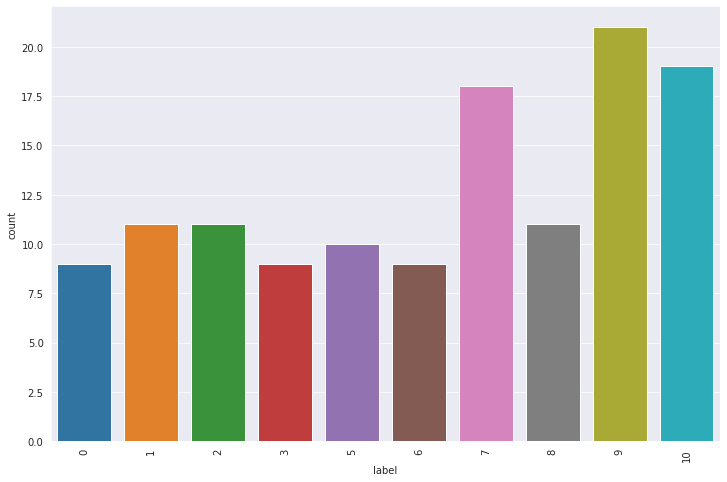

In [154]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(val_data.label)

## Validation Data Pre-processing

In [155]:
from pathlib import Path
for i in tqdm(range(len(val_data))):
  if not Path(val_data['filepaths'][i]).is_file:
    print ("Error", i,val_data['filepaths'][i],val_data['label'][i])

100%|██████████| 128/128 [00:00<00:00, 69660.17it/s]


In [156]:
#@title
data = []     # initialize an empty numpy arrayis_file
for i in tqdm(range(len(val_data))):
  img_array = cv2.imread(val_data['filepaths'][i])   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  data.append([new_img_array, val_data['label'][i]])
  #data.append([img_array, val_data['label'][i]])

100%|██████████| 128/128 [00:00<00:00, 637.89it/s]


In [157]:
#@title
np.random.shuffle(data)

#### Separating the images and labels


In [158]:
#@title
x_val = []
y_val = []
for image in data:
  x_val.append(image[0])
  y_val.append(image[1])

# converting x & y to numpy array as they are list
x_val = np.array(x_val)
y_val = np.array(y_val)

In [159]:
#@title
np.unique(y_val, return_counts=True)

(array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10]),
 array([ 9, 11, 11,  9, 10,  9, 18, 11, 21, 19]))

## Plotting some validation images


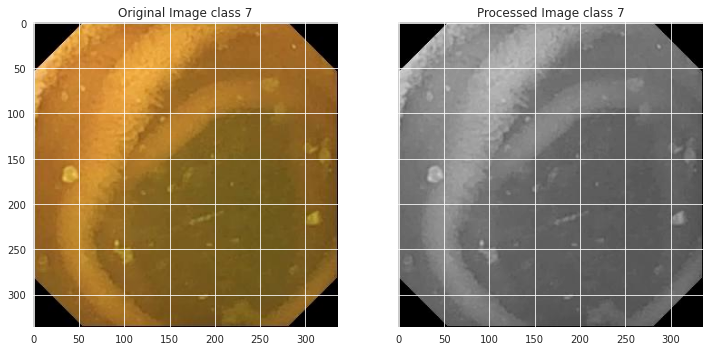

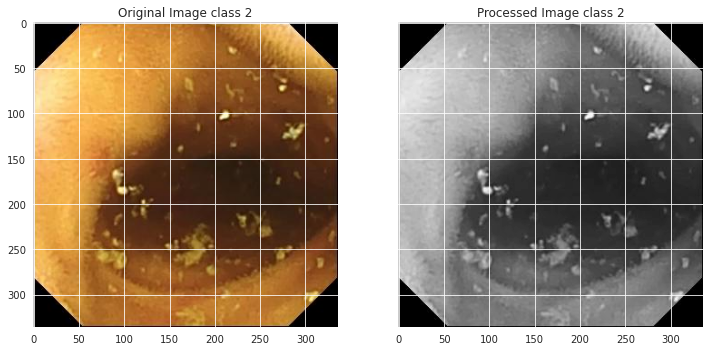

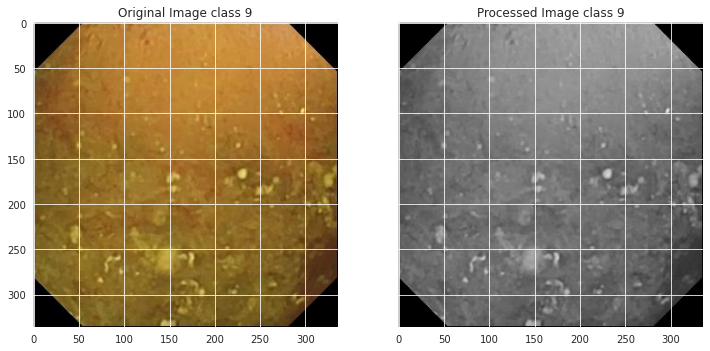

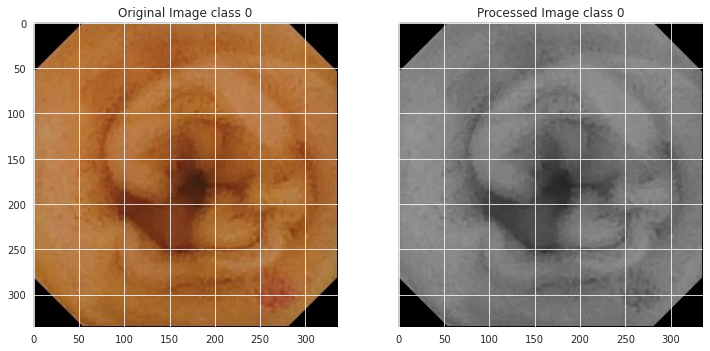

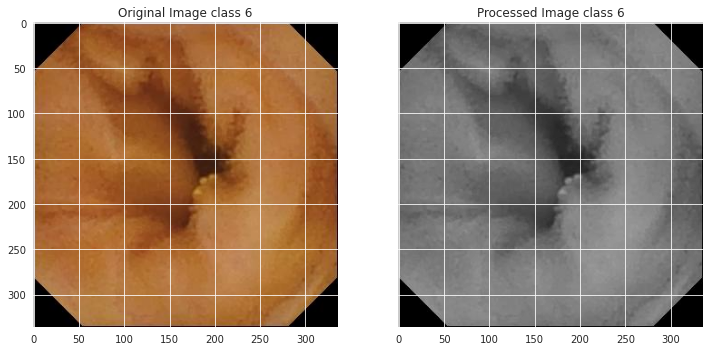

In [160]:
#@title
for i in range(5):
  i = np.random.randint(0, len(val_data) - 1)
  show_image(val_data['filepaths'][i],val_data['label'][i])

In [161]:
#@title


# **Training**

## Generating the model

In [162]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, image_bands)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(11, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 43264)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

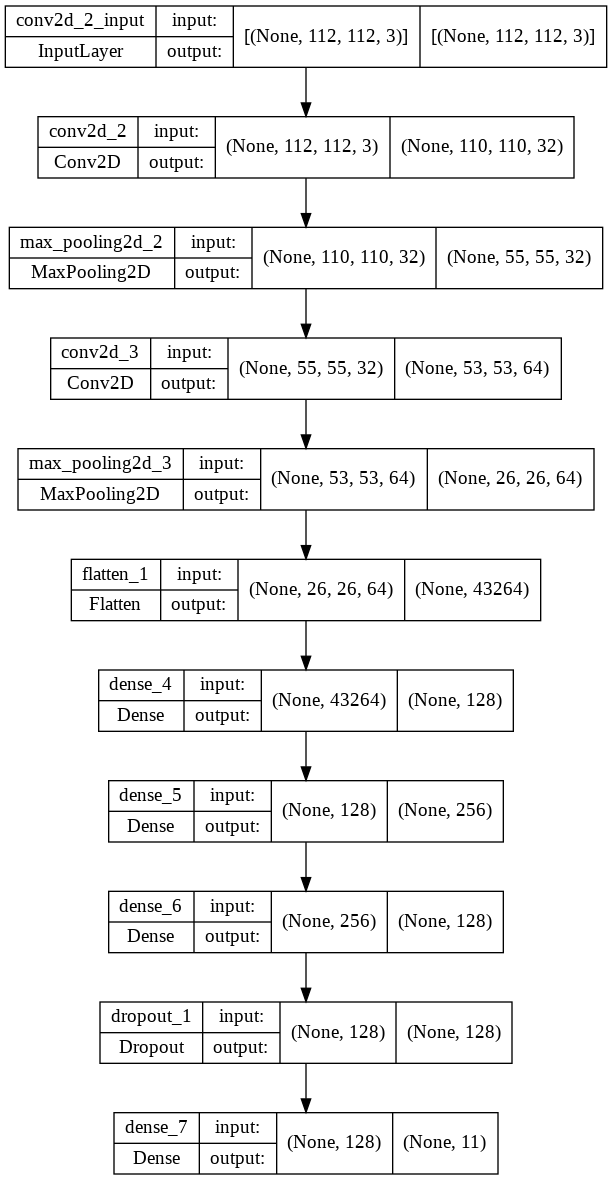

In [163]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [164]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy','crossentropy'])

In [165]:
gpu_info = !nvidia-smi -L
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

GPU 0: Tesla T4 (UUID: GPU-20afbe8c-4749-5033-2498-dfad7d30c5bf)


In [166]:
model_filepath = drive_path + drive_project_path + drive_test_path +  model_name
model_filepath

'/content/drive/MyDrive/ML_Capstone/test/model_cnn_lumaro'

In [167]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_filepath,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [168]:
if retrain:
  model.load_weights(model_filepath)

## Fiting the model

In [169]:
train_history = model.fit(x_train, y_train, 
                          epochs=num_epochs, batch_size=1024,
                          validation_data=(x_val, y_val),
                          class_weight=dic_weights,
                          callbacks=[cp_callback])

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 3.9645 - accuracy: 0.1176 - crossentropy: 27.9621
Epoch 1: val_loss improved from inf to 233.69232, saving model to /content/drive/MyDrive/ML_Capstone/test/model_cnn_lumaro
1/1 [==============================] - 1s 1s/step - loss: 3.9645 - accuracy: 0.1176 - crossentropy: 27.9621 - val_loss: 233.6923 - val_accuracy: 0.0000e+00 - val_crossentropy: 233.6923
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 31.3591 - accuracy: 0.1008 - crossentropy: 321.8625
Epoch 2: val_loss did not improve from 233.69232
1/1 [==============================] - 0s 98ms/step - loss: 31.3591 - accuracy: 0.1008 - crossentropy: 321.8625 - val_loss: 464.4709 - val_accuracy: 0.0859 - val_crossentropy: 464.4709
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 23.5245 - accuracy: 0.0672 - crossentropy: 434.4219
Epoch 3: val_loss did not improve from 233.69232
1/1 [==============================] - 0s 93ms/step - los

In [170]:
model_filepath = drive_path + drive_project_path + drive_test_path +  model_name
model_filepath

'/content/drive/MyDrive/ML_Capstone/test/model_cnn_lumaro'

In [171]:
train_history.history.keys()

dict_keys(['loss', 'accuracy', 'crossentropy', 'val_loss', 'val_accuracy', 'val_crossentropy'])

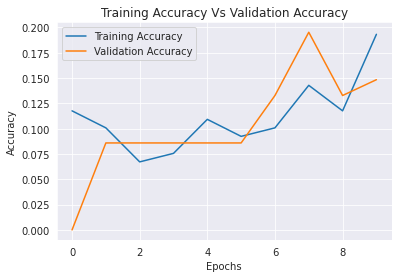

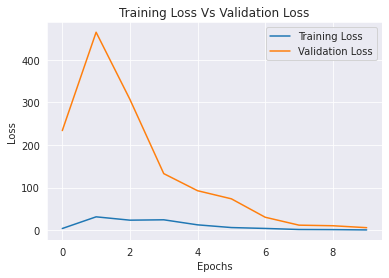

In [172]:
#PLOT HISTORY
plt.plot(train_history.history['accuracy'],label='Training Accuracy')
plt.plot(train_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.legend()
plt.show()
#
plt.plot(train_history.history['loss'],label='Training Loss')
plt.plot(train_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Vs Validation Loss')
plt.legend()
plt.show()

## Evaluating the model

In [173]:
train_eval = model.evaluate(x_val, y_val)

4/4 [==============================] - 0s 8ms/step - loss: 5.9066 - accuracy: 0.1484 - crossentropy: 5.9066


In [174]:
train_eval

[5.9065704345703125, 0.1484375, 5.9065704345703125]

# **Make Prediction and Analysis on Validation Dataset**


In [175]:
pred = model.predict(x_val)
prediction = []
for value in pred:
  prediction.append(np.argmax(value))

In [176]:
def test_model(y_true, y_predicted):
    print("Accuracy = {:.3f}".format(mtc.accuracy_score(y_true, y_predicted)))
    print("Accuracy Balanced = {:.3f}".format(mtc.balanced_accuracy_score(y_true, y_predicted)))
    
    print("Precision micro = {:.3f}".format(mtc.precision_score(y_true,y_predicted, average="micro")))
    print("Precision macro = {:.3f}".format(mtc.precision_score(y_true,y_predicted, average="macro")))
    print("Precision weighted = {:.3f}".format(mtc.precision_score(y_true,y_predicted, average="weighted")))
    
    print("Recall micro = {:.3f}".format(mtc.recall_score(y_true, y_predicted, average="micro")))
    print("Recall macro = {:.3f}".format(mtc.recall_score(y_true, y_predicted, average="macro")))
    print("Recall weighted = {:.3f}".format(mtc.recall_score(y_true, y_predicted, average="weighted")))

    print("F1 micro = {:.3f}".format(mtc.f1_score(y_true, y_predicted, average="micro")))
    print("F1 macro = {:.3f}".format(mtc.f1_score(y_true, y_predicted, average="macro")))
    print("F1 weighted = {:.3f}".format(mtc.f1_score(y_true, y_predicted, average="weighted")))

    print("MCC = {:.3f}".format(mtc.matthews_corrcoef(y_true, y_predicted)))
    print("Kappa = {:.3f}".format(mtc.cohen_kappa_score(y_true, y_predicted)))


In [177]:
test_model(y_val, prediction)

Accuracy = 0.148
Accuracy Balanced = 0.161
Precision micro = 0.148
Precision macro = 0.138
Precision weighted = 0.181
Recall micro = 0.148
Recall macro = 0.161
Recall weighted = 0.148
F1 micro = 0.148
F1 macro = 0.087
F1 weighted = 0.092
MCC = 0.088
Kappa = 0.069


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [178]:
#classification_report
report = classification_report(y_val, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.31      1.00      0.48        11
           2       0.07      0.45      0.12        11
           3       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        21
          10       1.00      0.16      0.27        19

    accuracy                           0.15       128
   macro avg       0.14      0.16      0.09       128
weighted avg       0.18      0.15      0.09       128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [179]:
# confusion matrix
cm = pd.DataFrame(confusion_matrix(y_val, prediction))
cm

,0,1,2,3,4,5,6,7,8,9
0,0,0,9,0,0,0,0,0,0,0
1,0,11,0,0,0,0,0,0,0,0
2,0,3,5,0,0,3,0,0,0,0
3,0,0,9,0,0,0,0,0,0,0
4,0,0,10,0,0,0,0,0,0,0
5,0,0,9,0,0,0,0,0,0,0
6,0,0,5,0,0,13,0,0,0,0
7,0,5,6,0,0,0,0,0,0,0
8,0,0,21,0,0,0,0,0,0,0
9,0,16,0,0,0,0,0,0,0,3


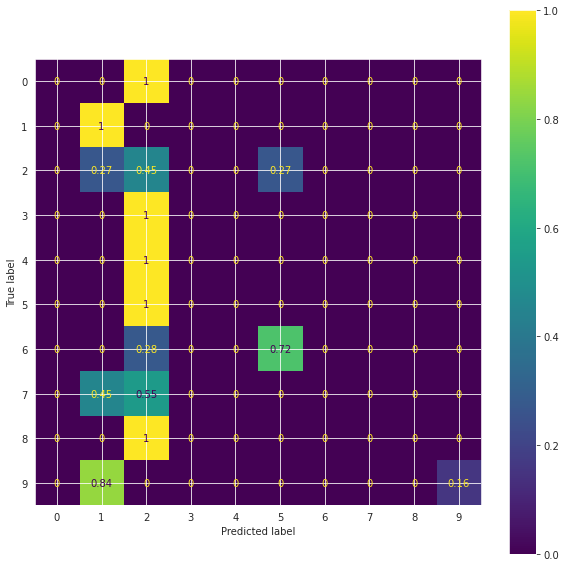

In [180]:
# confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_val, prediction, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(range(11)))
disp.plot(ax=ax)